PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121
압축 해제가 완료되었습니다. './data' 폴더가 생성되었습니다.

학습을 위해 설정된 데이터 경로는 './data/sample_computer_vision' 입니다.
Using device: cuda:0
Classes found: ['cats', 'dogs']

--- 데이터셋 시각화 ---


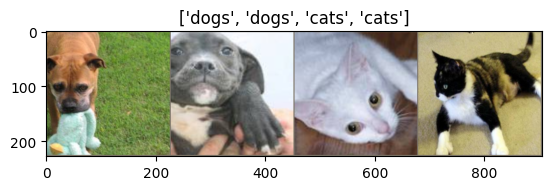


--- 모델 학습 시작 ---
Epoch 0/14
----------
train Loss: 0.5409 Acc: 0.7655
val Loss: 0.2734 Acc: 0.9000

Epoch 1/14
----------
train Loss: 0.4750 Acc: 0.8094
val Loss: 0.1368 Acc: 0.9650

Epoch 2/14
----------
train Loss: 0.5118 Acc: 0.7994
val Loss: 0.1101 Acc: 0.9650

Epoch 3/14
----------
train Loss: 0.4349 Acc: 0.8253
val Loss: 0.2534 Acc: 0.9300

Epoch 4/14
----------
train Loss: 0.6265 Acc: 0.7974
val Loss: 0.2148 Acc: 0.9050

Epoch 5/14
----------
train Loss: 0.4605 Acc: 0.8194
val Loss: 0.5519 Acc: 0.7500

Epoch 6/14
----------
train Loss: 0.4833 Acc: 0.8114
val Loss: 0.1010 Acc: 0.9700

Epoch 7/14
----------
train Loss: 0.3364 Acc: 0.8613
val Loss: 0.0909 Acc: 0.9650

Epoch 8/14
----------
train Loss: 0.3022 Acc: 0.8663
val Loss: 0.0983 Acc: 0.9650

Epoch 9/14
----------
train Loss: 0.3095 Acc: 0.8523
val Loss: 0.0783 Acc: 0.9800

Epoch 10/14
----------
train Loss: 0.3339 Acc: 0.8413
val Loss: 0.0864 Acc: 0.9750

Epoch 11/14
----------
train Loss: 0.2859 Acc: 0.8942
val Loss: 0.09

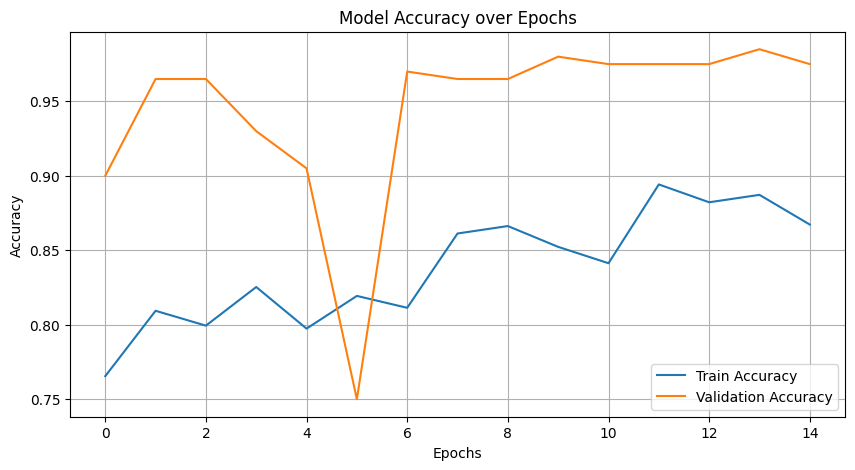


--- 예측 결과 시각화 ---


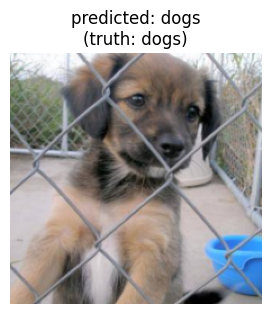

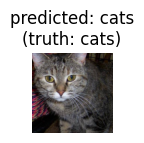

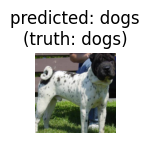

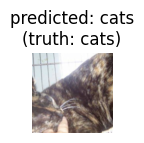

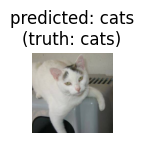

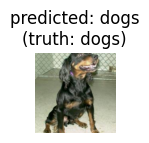

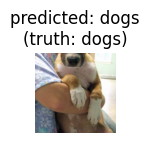

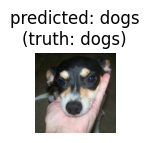

In [11]:
# 1. 필요한 라이브러리 가져오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

# 2. 업로드된 zip 파일 압축 해제
zip_file_path = 'sample_computer_vision.zip'
output_directory = './data'

# 기존 폴더가 있으면 삭제하여 깨끗한 상태에서 시작
if os.path.exists(output_directory):
    !rm -rf {output_directory}

if os.path.exists(zip_file_path):
    !unzip -q -o {zip_file_path} -d {output_directory}
    print(f"압축 해제가 완료되었습니다. '{output_directory}' 폴더가 생성되었습니다.")
else:
    print(f"'{zip_file_path}'를 찾을 수 없습니다. 파일을 Colab 세션 저장소에 업로드해주세요.")



base_path = './data'
# data 폴더 내에 폴더가 하나만 있다면, 그 폴더를 data_dir로 가정
potential_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
if len(potential_dirs) == 1:
    data_dir = os.path.join(base_path, potential_dirs[0])
else:
  data_dir = base_path

print(f"\n학습을 위해 설정된 데이터 경로는 '{data_dir}' 입니다.")

# 이미지 변환 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# ImageFolder를 사용하여 데이터셋 로드
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Classes found: {class_names}")

# 이미지 시각화 함수
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 학습 데이터 시각화
print("\n--- 데이터셋 시각화 ---")
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# 모델 학습을 위한 함수 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 훈련(train)과 검증(val) 단계를 가집니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복해서 가져옵니다.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # 파라미터 경사도를 0으로 초기화

                # 순전파 (Forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 훈련 단계일 경우 역전파(backward) + 최적화(optimize) 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 수집
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 가장 성능이 좋은 모델 가중치를 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 좋은 모델 가중치를 로드하여 반환
    model.load_state_dict(best_model_wts)
    return model, history

# 사전 학습된 ResNet-18 모델 로드
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 마지막 Fully Connected Layer를 우리 데이터셋의 클래스 수(2개: cats, dogs)에 맞게 수정
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device) # 모델을 GPU로 이동

criterion = nn.CrossEntropyLoss() # 손실 함수 정의
# 옵티마이저 정의 (학습 과정에서 모델의 가중치를 업데이트하는 방법)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 학습률 스케줄러 (학습이 진행됨에 따라 학습률을 동적으로 조정)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 학습 시작
print("\n--- 모델 학습 시작 ---")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

# 4. 학습 로그(정확도) 시각화
print("\n--- 학습 로그 시각화 ---")

plt.figure(figsize=(10, 5))
plt.title("Model Accuracy over Epochs")
plt.plot(history['train_acc'], label="Train Accuracy")
plt.plot(history['val_acc'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 5. 예측 결과 시각화
def visualize_model_predictions(model, num_images=8):
    was_training = model.training
    model.eval() # 모델을 평가 모드로 설정
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad(): # 예측 시에는 경사도를 계산할 필요가 없음
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\n(truth: {class_names[labels[j]]})')

                # imshow 함수는 CPU 텐서를 입력으로 받으므로 .cpu() 호출
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) # 원래 모드로 복귀
                    return
    model.train(mode=was_training)

print("\n--- 예측 결과 시각화 ---")
visualize_model_predictions(model_ft, num_images=8)